In [ ]:
import pandas as pd
import string
import nltk
import pickle
import os
import random
from nltk.corpus import stopwords, wordnet
from nltk.classify import NaiveBayesClassifier
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

ENGLISH_STOPWORDS = stopwords.words('english')
PUNCTUATIONS = string.punctuation
LEMMATIZER = WordNetLemmatizer()
STEMMER = PorterStemmer()

dataset = []
comments = ""
classifier = 0
list_words = []
labeled = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Import Data

def init():
    data_komentar = pd.read_csv("comments.csv")
    Data = data_komentar.iloc[:, :].values
    random.shuffle(Data)
    print(Data)

    global list_words
    global labeled
    for d in Data:
        try:
            sentences = d[0].lower()
        except:
            continue

        words = word_tokenize(sentences)
        words = [word for word in words if word not in ENGLISH_STOPWORDS]
        words = [LEMMATIZER.lemmatize(word) for word in words]
        words = [word for word in words if word not in PUNCTUATIONS]
        words = [word for word in words if word.isalpha()]
        for w in words:
            list_words.append(w)
        labeled.append((d[0], d[1]))

    fd = FreqDist(list_words)
    list_words = [word for word, count in fd.most_common(100)]

init()

[['Which TV Female Friend Group Do You Belong In' 1]
 ['The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills'
  1]
 ['This Vine Of New York On "Celebrity Big Brother" Is Fucking Perfect' 1]
 ...
 ['U.S. asks Czech Republic to grant asylum to Guantanamo Bay prisoners'
  0]
 ["23 Weird Things You Won't See On Display In A Science Museum" 1]
 ['Things Salvadoran-Americans Are Tired Of Hearing' 1]]


In [ ]:
# Data Training and Testing

def training():
    global dataset
    global labeled
    for sentence, label in labeled:
        words = word_tokenize(sentence)
        words = [word for word in words if word not in ENGLISH_STOPWORDS]
        words = [LEMMATIZER.lemmatize(word) for word in words]
        words = [word for word in words if word not in PUNCTUATIONS]
        words = [word for word in words if word.isalpha()]

        try:
            label_int = int(label)
            if label_int == 0:
                newlabel = "negative"
            elif label_int == 1:
                newlabel = "positive"
            else:
                continue

            features = {}
            for feature in list_words:
                key = feature
                value = feature in words
                features[key] = value
            dataset.append((features, newlabel))
        except ValueError:
            pass

    percentage = int(len(dataset) * 0.9)
    training_data = dataset[:percentage]
    testing_data = dataset[percentage:]

    global classifier
    classifier = NaiveBayesClassifier.train(training_data)

    print("  ", end = "")
    classifier.show_most_informative_features(5)
    print("MODEL TRAINING ACCURACY: " + str(accuracy_score([label for features, label in testing_data],
     [classifier.classify(features) for features, label in testing_data]) * 100) + " %")

    # Evaluation
    y_true = [label for features, label in testing_data]
    y_pred = [classifier.classify(features) for features, label in testing_data]

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

    file = open("model.pickle", "wb")
    pickle.dump(classifier, file)
    file.close()

training()

  Most Informative Features
                    sign = True           negati : positi =    113.7 : 1.0
                   based = True           negati : positi =     16.2 : 1.0
                     new = False          positi : negati =      1.0 : 1.0
                     say = False          positi : negati =      1.0 : 1.0
                   first = False          positi : negati =      1.0 : 1.0
MODEL TRAINING ACCURACY: 60.390625 %

Classification Report:

              precision    recall  f1-score   support

    negative       1.00      0.11      0.20      2859
    positive       0.58      1.00      0.74      3541

    accuracy                           0.60      6400
   macro avg       0.79      0.56      0.47      6400
weighted avg       0.77      0.60      0.50      6400



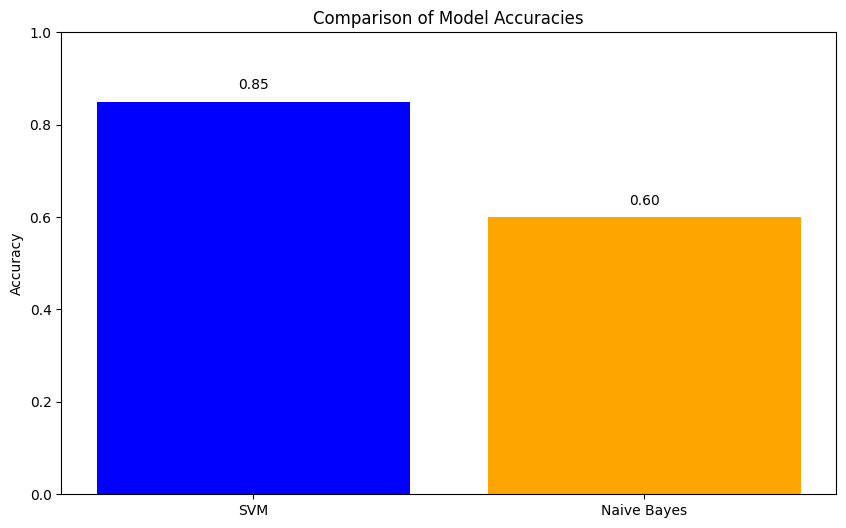

In [ ]:
# Grafik perbandingan

import matplotlib.pyplot as plt

accuracy_svm = 0.85
accuracy_nb = 0.60

labels = ['SVM', 'Naive Bayes']
accuracies = [accuracy_svm, accuracy_nb]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

plt.show()